In [ ]:
import pandas as pd
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt

# Get and Load the Pima Indians Diabetes dataset

We download the data from an nrvis repository. And we load it into a pandas dataframe.

In [ ]:
!wget http://nrvis.com/data/mldata/pima-indians-diabetes.csv

--2021-01-06 00:02:40--  http://nrvis.com/data/mldata/pima-indians-diabetes.csv
Resolving nrvis.com (nrvis.com)... 173.236.176.48
Connecting to nrvis.com (nrvis.com)|173.236.176.48|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23279 (23K) [text/csv]
Saving to: ‘pima-indians-diabetes.csv.3’

pima-indians-diabet 100%[===================>]  22.73K   121KB/s    in 0.2s    

2021-01-06 00:02:40 (121 KB/s) - ‘pima-indians-diabetes.csv.3’ saved [23279/23279]



In [ ]:
df = pd.read_csv('pima-indians-diabetes.csv',header=None)
# 0. Number of times pregnant
# 1. Plasma glucose concentration a 2 hours in an oral glucose tolerance test
# 2. Diastolic blood pressure (mm Hg)
# 3. Triceps skin fold thickness (mm)
# 4. 2-Hour serum insulin (mu U/ml)
# 5. Body mass index (weight in kg/(height in m)^2)
# 6. Diabetes pedigree function
# 7. Age (years)
# 8. Class variable (0 or 1)
df.columns = ["NumTimesPrg", "PlGlcConc", "BloodP", "SkinThick", "TwoHourSerIns", "BMI", "DiPedFunc", "Age", "HasDiabetes"]

# Split data into Train and Test Sets

We set aside 20% of the data for analysis after our predictive model is trained.

In [ ]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df,test_size=0.2, random_state=0)

# Train a Logistic Regression model on the training set

We use the statmodels Logit model, and print its coefficients.

In [ ]:
import statsmodels.api as sm

X = df_train.iloc[:,range(8)]
Y = df_train.iloc[:,8]

X = sm.add_constant(X)

model = sm.Logit(Y, X).fit()

Optimization terminated successfully.
         Current function value: 0.483040
         Iterations 6


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
print(model.summary())

                           Logit Regression Results                           
Dep. Variable:            HasDiabetes   No. Observations:                  614
Model:                          Logit   Df Residuals:                      605
Method:                           MLE   Df Model:                            8
Date:                Wed, 06 Jan 2021   Pseudo R-squ.:                  0.2607
Time:                        00:02:41   Log-Likelihood:                -296.59
converged:                       True   LL-Null:                       -401.18
Covariance Type:            nonrobust   LLR p-value:                 7.418e-41
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -8.1937      0.780    -10.507      0.000      -9.722      -6.665
NumTimesPrg       0.0914      0.034      2.664      0.008       0.024       0.159
PlGlcConc         0.0339      0.004     

From these coefficients (coef column), we expect that higher values of NumTimesPrg, PlGlcConc, BMI, and DiPedFunc, will all cause our predicted probabilities of diabetes to be higher, while for the other variables (BloodP, and TwoHourSerIns), lower values will cause our probabilities of diabetes to be higher.  For variables where coef is very nearly 0 and the `P>|z|` is much greater than 0.05, we expect there to be little effect on the outcome

# Generate predictions on the test dataset

We use our model to generate prediction probabilites (range 0-1) on our test dataset.  The higher the prediction probability, the more confident our model is that the individual would have diabetes.

In [ ]:
y_pred = model.predict(sm.add_constant(df_test.iloc[:,range(8)]))
y_pred.name='prediction'
res = pd.concat([df_test, y_pred],axis=1)

# Sensitivity Analysis 1: Features of most confident incorrect predictions

In this sensitivity analysis, we aim to see what features led to the algorithm making mistakes in classification even though it was very confident.

We start with samples where the prediction was confident that they had diabetes, but they did not actually have diabetes.

In [ ]:
res.loc[res['HasDiabetes']==0].sort_values('prediction',ascending=False).head(5)

,NumTimesPrg,PlGlcConc,BloodP,SkinThick,TwoHourSerIns,BMI,DiPedFunc,Age,HasDiabetes,prediction
622,6,183,94,0,0,40.8,1.461,45,0,0.955608
744,13,153,88,37,140,40.6,1.174,39,0,0.912510
40,3,180,64,25,70,34.0,0.271,26,0,0.745294
258,1,193,50,16,375,25.9,0.655,24,0,0.655646
267,2,128,64,42,0,40.0,1.101,24,0,0.650987


It's hard to see directly from this table which characteristics are higher or lower than average so let us compare them normalized by the mean and standard deviation of each column.

In [ ]:
((res.loc[res['HasDiabetes']==0].sort_values('prediction',ascending=False).head(5) - res.mean())/res.std()).iloc[:,range(8)]

,NumTimesPrg,PlGlcConc,BloodP,SkinThick,TwoHourSerIns,BMI,DiPedFunc,Age
622,0.741709,1.898277,1.363481,-1.294758,-0.667085,1.249918,2.987125,1.242540
744,3.026171,0.981388,1.041102,1.078202,0.657989,1.224043,2.101087,0.676412
40,-0.237347,1.806588,-0.248413,0.308593,-0.004548,0.370153,-0.686690,-0.550198
258,-0.890050,2.203906,-1.000631,-0.268613,2.882221,-0.677802,0.498810,-0.738907
267,-0.563699,0.217314,-0.248413,1.398872,-0.667085,1.146416,1.875719,-0.738907


now we can inspect each row .

- All of the rows had higher than average PlGlcConc
- rows 228 and 12 had higher DiPedFunc
- row 489 had average DiPedFunc but a much higher than average Age
- rows 327, 489 and 469 all had much lower skin thickness than average.

### Comparing with samples that did have diabetes

Next we can compare these to the top 5 samples where the prediction was confident that the individual would have diabetes, and the algorithm was correct.

In [ ]:
((res.loc[res['HasDiabetes']==1].sort_values('prediction',ascending=False).head(5) - res.mean())/res.std()).iloc[:,range(8)]

,NumTimesPrg,PlGlcConc,BloodP,SkinThick,TwoHourSerIns,BMI,DiPedFunc,Age
661,-0.890050,2.387284,0.396345,1.463006,-0.667085,1.521610,2.780280,-0.927616
546,0.415357,2.020528,0.396345,0.436861,1.292132,1.612174,1.668874,1.997377
408,1.394412,2.326158,0.288885,-1.294758,-0.667085,-0.677802,2.153570,0.676412
215,2.699820,0.920262,0.073966,1.270604,1.897880,1.379295,0.767400,0.582058
236,1.068060,1.837151,0.826183,0.052057,1.150159,0.615970,0.285790,1.808668


We can plot the results side by side for an easier comparison.

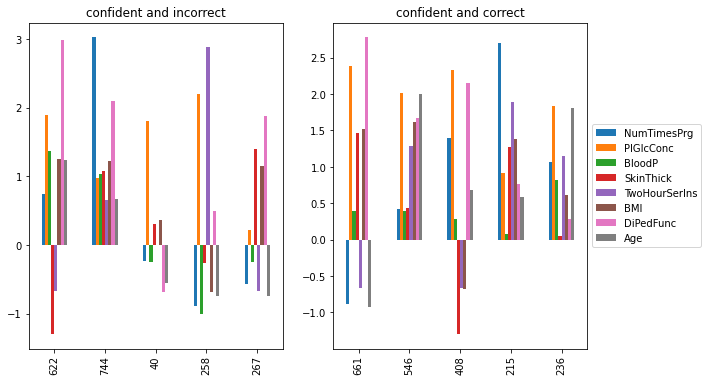

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(10,6))
((res.loc[res['HasDiabetes']==0].sort_values('prediction',ascending=False).head(5) - res.mean())/res.std()).iloc[:,range(8)].plot.bar(ax=ax[0],legend=False,title='confident and incorrect')
((res.loc[res['HasDiabetes']==1].sort_values('prediction',ascending=False).head(5) - res.mean())/res.std()).iloc[:,range(8)].plot.bar(ax=ax[1],title='confident and correct')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

While its hard to gather too much from these few data points, one feature that jumps out are the lower than average values of a few variables that may have caused 258 and 267 to be incorrectly labeled. 

Analysis like this can help point out which if any variables are leading the algorithm astray in extreme situations.

### Exercise for the Reader: Most confident incorrectly classified as non-diabetic

A very similar analysis can be performed on individuals who were confidently predicted to be non-diabetic. We leave this as an exercise for the reader.

# Working with a more complex model (Random Forest)
The findings for the logistic regression model follow directly from the values of the coefficients of the regression.  However, some models are not so amenable to inspection up front. In this section we reapply the same analysis to a Random Forest model where we cannot naively check the weight and direction of influence for each variable.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(random_state=0)

X = df_train.iloc[:,range(8)]
Y = df_train.iloc[:,8]

clf.fit(X, Y)

res['prediction_rf'] = clf.predict_proba(df_test.iloc[:,range(8)])[:,1]

Like last time we can analyze the most confident incorrect classifications.  Here we skip to the last figure from Sensitivity Analysis 1 for the direct comparison between those incorrectly classified who were truly diabetic or truly non-diabetic.

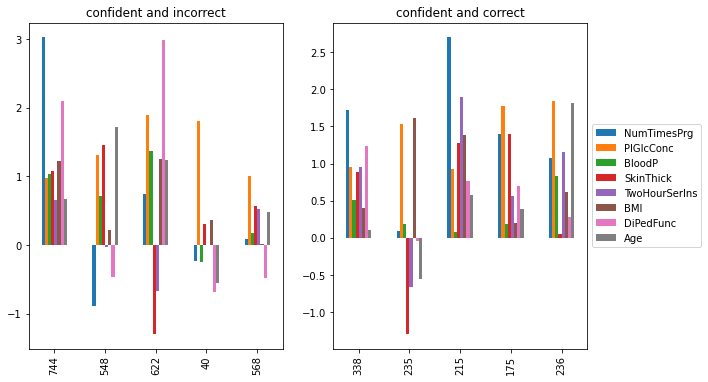

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(10,6))
((res.loc[res['HasDiabetes']==0].sort_values('prediction_rf',ascending=False).head(5) - res.mean())/res.std()).iloc[:,range(8)].plot.bar(ax=ax[0],legend=False,title='confident and incorrect')
((res.loc[res['HasDiabetes']==1].sort_values('prediction_rf',ascending=False).head(5) - res.mean())/res.std()).iloc[:,range(8)].plot.bar(ax=ax[1],title='confident and correct')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

One thing that leaps out is that, we see that the value of DiPedFunc was much higher in one example than in the correctly labeled ones.  This could potentially indicate that in that extreme regime, our model is going astray.  Perhaps our underlying dataset has few individuals with TwoHourSerIns values that high.  Further analysis could clarify the reason for this.

Since we did not see this with the Logistic Regression model, this suggests there could be a difference here in how the two underlying models operate.


### Additional analysis: comparing to the most ambigous case

Finally, we can try to compare our confident predictions to the ones where the predictions are less sure.  We consider our predictions ambiguous when the value of the predicted probability is close to 0.5, indicating that in our algorithms opinion, the individual is a coin toss for developing diabetes or not.

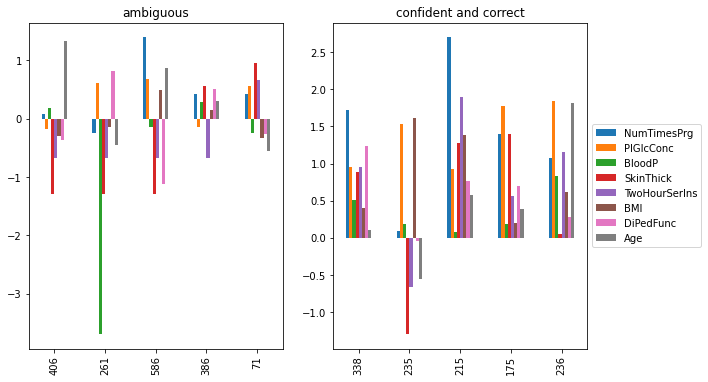

In [ ]:
res['pred_rf_05']=(res['prediction_rf']-0.5).abs()
fig, ax = plt.subplots(1,2,figsize=(10,6))
((res.sort_values('pred_rf_05').head(5) - res.mean())/res.std()).iloc[:,range(8)].plot.bar(ax=ax[0],legend=False,title='ambiguous')
((res.loc[res['HasDiabetes']==1].sort_values('prediction_rf',ascending=False).head(5) - res.mean())/res.std()).iloc[:,range(8)].plot.bar(ax=ax[1],title='confident and correct')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

While nothing too drastic leaps out, we can see that in one case the BloodP value was much lower than in other cases. Also there appears to be much more scatter around the average value for each feature in the majority of ambiguous cases.

# Conclusion

This notebook illustrated a suggested method for interrogating a model in a simple manner. While it can be helpful in explaining the model, it should be pointed out that analyzing just the top 5 elements is very limited and could easily lead to erroneous generalizations.  This method is only intended as a way to start the process of re-analyzing one's models and suggest possible areas of focus for further study.